# Examine Odd MLD

In [12]:
# imports
import os
import glob
import xarray

import numpy as np
from scipy import stats
from scipy.interpolate import interp1d 

from gsw import conversions, density
import gsw

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator 

import seaborn as sns

import pandas

from ocpy.utils import plotting

from cugn import grid_utils
from cugn import utils as cugn_utils
from cugn import io as cugn_io
from cugn import annualcycle
from cugn import defs

# Load CUGN

In [3]:
line = '90.0'
#
items = cugn_io.load_up(line)#, gextrem='low')
grid_extrem = items[0]
ds = items[1]
grid_tbl = items[3]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


In [10]:
lat = np.nanmedian(ds.lat.data)
lon = np.nanmedian(ds.lon.data)

In [5]:
high_path = os.path.join(os.getenv('OS_SPRAY'), 'CUGN', 'HighRes')
gfiles = glob.glob(os.path.join(high_path, f'SPRAY-FRSQ-{mname}-*.nc'))
hfile = gfiles[0]                   
#hfile
ds_high = xarray.open_dataset(hfile)

In [6]:
salinity = ds_high.salinity.values
temperature = ds_high.temperature.values

# Examine a Mission and Profile with a "bad" MLD

In [63]:
def do_calcs(mission_name:str, mission_profile:int, min_depth:float=0.5):
    
    gidx = (grid_extrem.mission.values == mission_name) & (
        grid_extrem.mission_profile.values == mission_profile)
    gMLD = np.median(grid_extrem.MLD.values[gidx])

    # Find the obs
    my_obs = ds_high.profile_obs_index.values == mission_profile
    my_obs &= ds_high.depth.values > min_depth

    # Calculate density, etc.

    # Require finite
    my_obs &= np.isfinite(salinity) & np.isfinite(temperature)

    # Pressure
    p = conversions.p_from_z(-1*ds_high.depth.values[my_obs], lat)

    # SA
    SA = conversions.SA_from_SP(salinity[my_obs], p, lon, lat)

    # CT
    CT = conversions.CT_from_t(SA, temperature[my_obs], p)

    # sigma0 
    sigma0 = density.sigma0(SA, CT)
    srt_z = np.argsort(ds_high.depth[my_obs])

    # sigma0 at surface
    sigma0_0 = np.mean(sigma0[srt_z[:5]])

    # Calculate MLD
    f = interp1d(sigma0[srt_z], ds_high.depth[my_obs].values[srt_z])
    MLD = f(sigma0_0 + defs.MLD_sigma0)

    # Return
    return my_obs, gMLD, MLD, sigma0

In [54]:
mname = '20503001'
in_grid = (grid_extrem.mission.values == mname)
np.unique(grid_extrem.mission_profile.values[in_grid])
#mprofile = 14  # If z=10m means average 5-15m
mprofile = 670

In [64]:
my_obs, gMLD, MLD, sigma0 = do_calcs(mname, mprofile)

In [65]:
gMLD, MLD

(np.float64(7.284050486606365), array(4.90055209))

# Examine the quantities

In [66]:
gidx = (grid_tbl.mission.values == mname) & (
    grid_tbl.mission_profile.values == mprofile)
gprofile = grid_tbl[gidx].profile.values[0]
gprofile

np.int32(44685)

In [67]:
srt_z = np.argsort(ds_high.depth[my_obs])
ds_high.depth.values[my_obs][srt_z][0:20]

array([ 2.105 ,  2.7802,  3.4553,  4.0114,  4.8057,  5.4809,  6.1163,
        6.8312,  7.5063,  8.3801,  9.095 ,  9.8495, 11.2793, 11.9941,
       12.8679, 13.5827, 14.3373, 14.933 , 15.6081, 16.4024])

## Salinity

In [68]:
ds_high.salinity.values[my_obs][srt_z][0:20]

array([33.765, 33.764, 33.741, 33.718, 33.697, 33.693, 33.671, 33.666,
       33.667, 33.668, 33.659, 33.655, 33.652, 33.64 , 33.637, 33.634,
       33.626, 33.598, 33.613, 33.61 ])

In [69]:
ds.salinity.data[0:3,gprofile]

array([33.65123077, 33.59208333, 33.55391667])

## Profile

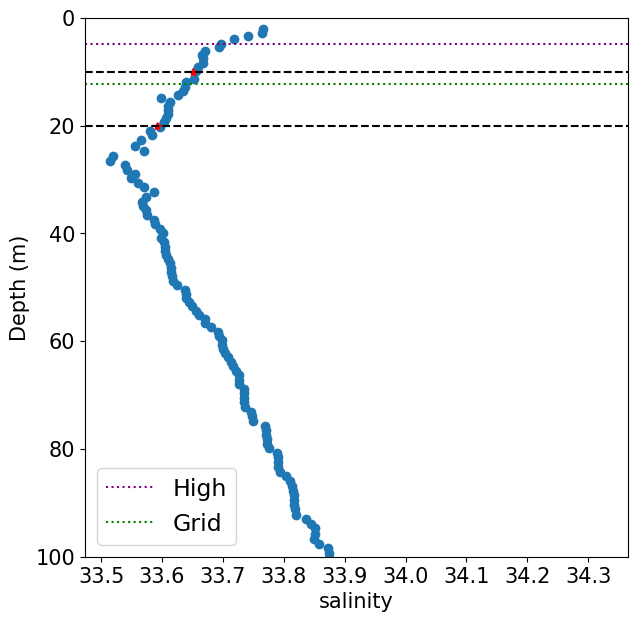

In [71]:
q = 'salinity'
#q = 'temperature'
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
ax.plot(ds_high[q].values[my_obs], ds_high.depth[my_obs], 'o')
#
ax.set_xlabel(q)
ax.set_ylabel('Depth (m)')
#
ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
# Add grid values
for layer in [0,1]:
    ax.plot(ds[q].data[layer, gprofile], ds.depth[layer], 'r*')
    
#
for depth in [10, 20.]:
    ax.axhline(depth, color='k', ls='--')
# MLD
ax.axhline(MLD, color='purple', ls=':', label='High')
ax.axhline(gMLD+5, color='g', ls=':', label='Grid')
#
ax.legend(fontsize=17.)
#
plt.show()

----

In [52]:
ds.depth

<xarray.DataArray 'depth' (depth: 50)> Size: 200B
array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280,
       290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440, 450, 460, 470, 480, 490, 500], dtype=int32)
Coordinates:
  * depth    (depth) int32 200B 10 20 30 40 50 60 70 ... 450 460 470 480 490 500
Attributes:
    long_name:              Depth
    standard_name:          depth
    units:                  m
    positive:               down
    coverage_content_type:  coordinate

In [74]:
ds_high.latitude.data

array([32.83397  , 32.8326125, 32.8336925, ..., 32.9018675, 32.898075 ,
       32.896155 ])

In [75]:
ds_high

<xarray.Dataset> Size: 203MB
Dimensions:                     (trajectory: 1, profile: 1004, obs: 1104091)
Coordinates:
  * trajectory                  (trajectory) |S19 19B b'sp030-20200513T1702'
  * profile                     (profile) float64 8kB 1.0 2.0 ... 1.004e+03
    time                        (profile) datetime64[ns] 8kB ...
    latitude                    (profile) float64 8kB 32.83 32.83 ... 32.9 32.9
    latitude_uv                 (profile) float64 8kB ...
    longitude                   (profile) float64 8kB ...
    longitude_uv                (profile) float64 8kB ...
    time_uv                     (profile) datetime64[ns] 8kB ...
    depth                       (obs) float64 9MB 0.0397 0.0 ... 2.78 1.867
Dimensions without coordinates: obs
Data variables: (12/54)
    profile_obs_index           (obs) float64 9MB 1.0 1.0 ... 1.004e+03
    row_size                    (profile) int32 4kB ...
    time_qc                     (profile) float64 8kB ...
    latitude_qc                 (profile) float64 8kB ...
    latitude_uv_qc              (profile) float64 8kB ...
    longitude_qc                (profile) float64 8kB ...
    ...                          ...
    gps_end_qc_tests            (profile) float64 8kB ...
    wmo_id                      <U7 28B ...
    instrument_doxy             float64 8B ...
    instrument_ctd              float64 8B ...
    instrument_fchl             float64 8B ...
    platform_meta               float64 8B ...
Attributes: (12/65)
    Conventions:                   CF-1.8, COARDS, ACDD-1.3
    acknowledgement:               Funded by National Oceanic and Atmospheric...
    cdm_profile_variables:         profile,time,latitude,longitude
    cdm_trajectory_variables:      trajectory
    comment:                       This file contains data from the following...
    contributor_name:              Daniel Rudnick, Jennifer Sevadjian
    ...                            ...
    time_coverage_duration:        P0000-03-19T23:09:53
    time_coverage_end:             2020-09-02T16:12:26Z
    time_coverage_resolution:      P0000-00-00T00:00:04
    time_coverage_start:           2020-05-13T17:02:33Z
    title:                         Science Quality Full-Resolution Data from ...
    history:                       2020-09-14T16:18:20Z: KDZ readflasho63(gps...